In [33]:
from matplotlib import pyplot as plt
import numpy as np
import os

from dataset import Dataset

In [106]:
class Result:
    def __init__(self, path, dataset):
        self.path = path
        self.dataset = dataset

    def plot_training(self, ax):
        """Plot train/val/test curves."""
        
        data = np.load(self.path)
        
        keys = ['train_loss', 'val_loss', 'test_loss']
        names = ['train', 'val', 'test']
        colors = ['C0', 'C1', 'C2']

        for key, color in zip(keys, colors):
            ax.plot(np.mean(data[key], axis=1).T, color=color)

        ax.legend([Line2D([0], [0], color=c, lw=2) for c in colors], names)

    def predictions(self, data=None):
        """Get best predictions based on val loss."""
        if data is None:
            data = np.load(self.path)
        best = jnp.argmin(jnp.mean(data["val_loss"], axis=1), axis=1)
        return data["predictions"][np.arange(100), best]

    def compare(self):
        """Compare predictions with baseline."""
        
        def _compare(base, pred, test):
            return ds.error(base, indices=test), ds.error(pred, indices=test)
        
        data = np.load(self.path)
        y_base, y_mf = vmap(_compare)(
            data["baseline"], self.predictions(data), data["test_split"])
        return np.array(y_base), np.array(y_mf)

    def compare_plot(self, ax, comparison=None):
        """Compare and plot as histogram."""
        if comparison is None:
            comparison = self.compare()
        base, mf = self.compare()

        left = np.minimum(np.min(base), np.min(mf))
        right = np.maximum(np.max(base), np.max(mf))
        bins = np.linspace(left, right, 50)
        
        ax.hist(base, bins=bins, label='Baseline', alpha=0.5)
        ax.hist(mf, bins=bins, label='Matrix Factorization', alpha=0.5)
        
        ax.axvline(np.mean(base), linestyle='--', color='C0')
        ax.axvline(np.mean(mf), linestyle='--', color='C1')


In [107]:
ptrain = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
ds = Dataset("data.npz", offset=1000 * 1000)
results = [Result("results/embedding/{}.npz".format(p), ds) for p in ptrain]
comparisons = [res.compare() for res in results]

Text(0, 0.5, 'Mean Absolute Error')

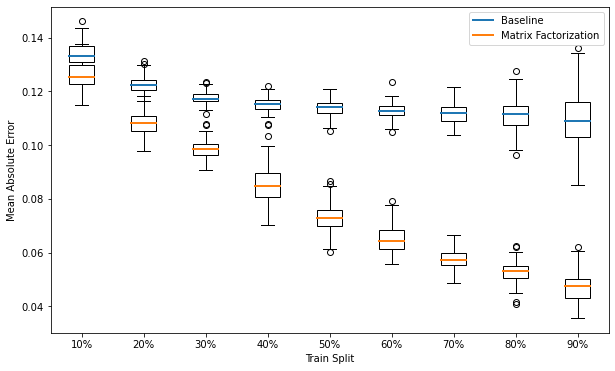

In [177]:
def _boxplot(ax, data, color, **kwargs):
    boxplot = ax.boxplot(data, patch_artist=True, **kwargs)
    for median in boxplot['medians']:
        median.set_color(color)
        median.set_linewidth(2)
    for box in boxplot['boxes']:
        box.set_facecolor('white')


fig, axs = plt.subplots(1, 1, figsize=(10, 6))
baseline, embedding = map(np.array, zip(*comparisons))
pos = np.arange(len(ptrain))

_boxplot(axs, baseline.T, 'C0', positions=pos, widths=0.4)
_boxplot(axs, embedding.T, 'C1', positions=pos, widths=0.4)

axs.legend(
    [Line2D([0], [0], color=c, lw=2) for c in ['C0', 'C1']],
    ['Baseline', 'Matrix Factorization'])

axs.set_xticks(pos)
axs.set_xticklabels(["{}%".format(int(p * 100)) for p in ptrain])
axs.set_xlabel("Train Split")
axs.set_ylabel("Mean Absolute Error")

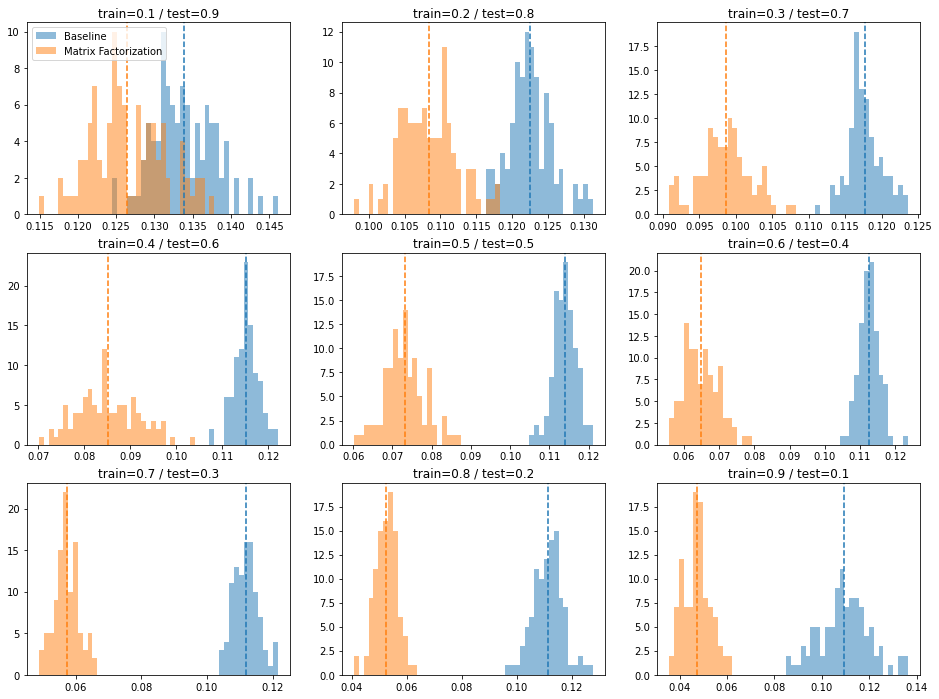

In [172]:
fig, axs = plt.subplots(3, 3, figsize=(16, 12))

spval = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for ax, sp, res, comparison in zip(axs.reshape(-1), spval, results, comparisons):
    res.compare_plot(ax, comparison)
    ax.set_title("train={:.1f} / test={:.1f}".format(sp, 1 - sp))
axs[0, 0].legend(loc='upper left')

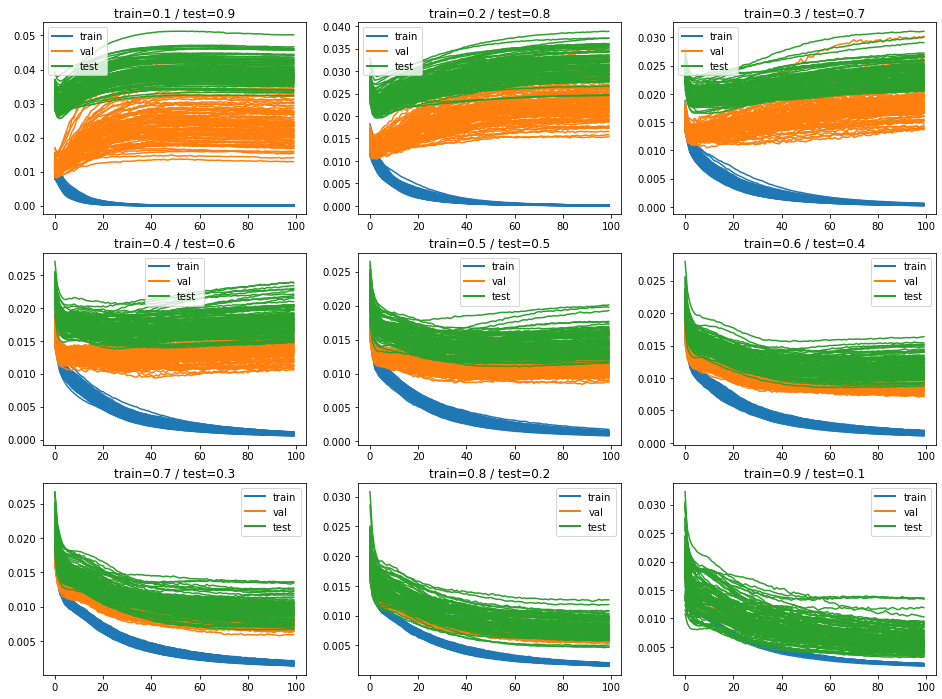

In [174]:
fig, axs = plt.subplots(3, 3, figsize=(16, 12))

spval = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for ax, sp, res, comparison in zip(axs.reshape(-1), spval, results, comparisons):
    res.plot_training(ax)
    ax.set_title("train={:.1f} / test={:.1f}".format(sp, 1 - sp))